<img src = "catvsdog.png">  
  
  # Cat vs Dog (Image Classification) 
  
Le but de ce projet est de construire un algorithme de classification des images (chien/chat) capable de prédir si une image correspond à un chat ou un chien à l'aide de Tensorflow et Keras API
 
  
    
 ### Importation des données

In [1]:
# Importation des librairies
import os
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [2]:
# Construction d'une foction pour dézipper le contenu des fichiers et exraire les images
def extract_files(source_path, target_path):
    zip_ref = zipfile.ZipFile(source_path,'r')
    zip_ref.extractall(target_path)
    zip_ref.close()
    
extract_files('train.zip', 'tree/') # Extraire les données d'entrainement
extract_files('test1.zip', 'tree/') # Extraire les données test

In [3]:
# Création d'un dataframe contenant le nom de l'image et sa catégorie
filenames = os.listdir("tree/train") # Lister les noms d'image sur le dossier train
train_cat = []
for filename in filenames:
    category = filename.split('.')[0] # Prendre le premier mot du nom de l'image (cat ou dog dans ce cas)
    if category == 'dog':
        train_cat.append("dog")
    else:
        train_cat.append("cat")

df = pd.DataFrame({
    'filename': filenames,
    'category': train_cat
})

# Jetons un coup d'oeil sur le dataframe
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [4]:
# les cinq dernières lignes du dataframe
df.tail()

,filename,category
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog
24999,dog.9999.jpg,dog


In [5]:
# Taille du dataframe
df.shape

(25000, 2)

### Visualisation de quelques images

Executez le code plusieurs fois pour voir plusieurs images à partir des données

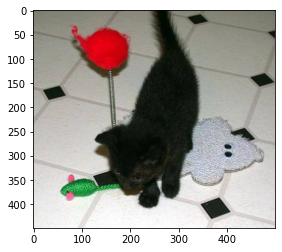

In [6]:
# Prenons une image au hasard pour la visualiser

sample = random.choice(filenames) # Choix d'un nom d'image au hasard

image = load_img("tree/train/" + sample) # Charger l'image choisie

plt.imshow(image) # Visualiser l'image

### Création du modèle

  
  <img src = "MODEL.png"> 
  
    
Notre modèle comporte:
- 3 couches avec des filtres de convolution (32, 64, 128) pour sélectionner les features sur les images, et avec des Maxpoolings pour réduire le volume d'image d'entrée après convolution.
- Un Dropout de 20% au cas du overfitting du modèle
- une couche de connexion avec 512 neurones
- une couche de sortie avec 2 neurones et le softmax comme fontion d'activation

In [7]:
model = tf.keras.models.Sequential([
    # La taille d'entrée est la taille d'image désirée 128x128 avec 2 bites de couleurs
    # Première convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Deuxième convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Troisième convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [8]:
# Création des callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

# Selon le besoin
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# On crée notre objet la reduction du taux d'apprentissage pour le moment
callbacks = myCallback()


In [9]:
# Spliter le dataframe en deux parties (entrainement et validation)
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

Text(0.5, 1.0, "Nombre d'images (dogs vs cats)")

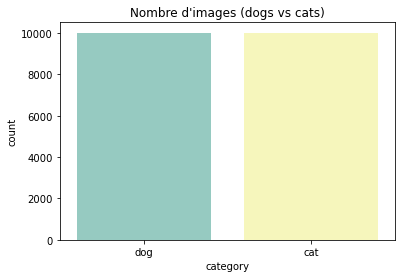

In [10]:
# Train data
sn.countplot(x = "category", data = train_df, palette = "Set3")
plt.title("Nombre d'images (dogs vs cats)")

Text(0.5, 1.0, "Nombre d'images (dogs vs cats)")

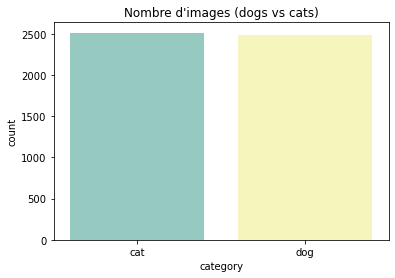

In [11]:
# Validation data
sn.countplot(x = "category", data = validate_df, palette = "Set3")
plt.title("Nombre d'images (dogs vs cats)")

### Création des générateurs

In [12]:
# Création du générateur
train_datagen = ImageDataGenerator(
    rotation_range = 15,  # Rotation 15 degré
    rescale = 1./255, # Normalisation
    shear_range = 0.1, # intensité de cisaillement dans le sens anti-horaire
    zoom_range = 0.2, # Zoomer sur les images
    horizontal_flip = True, # Activer l'effet miroir
    width_shift_range = 0.1, 
    height_shift_range = 0.1
)

# Appliquer le générateur sur les données d'entrainement
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "tree/train/", # Chemin des données
    x_col = 'filename',
    y_col = 'category',
    target_size = (128,128), # Fixer la taille de l'image
    class_mode = 'categorical', # Deux catégories cat/dog
    batch_size = 150 # Taille du lot
)

Found 20000 validated image filenames belonging to 2 classes.


In [13]:
# Création du générateur pour les données de validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Appliquer le générateur sur les données de validation
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "tree/train/", 
    x_col = 'filename',
    y_col = 'category',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = 150
)

Found 5000 validated image filenames belonging to 2 classes.


### Visualisation des résultats du générateur

Found 1 validated image filenames belonging to 1 classes.


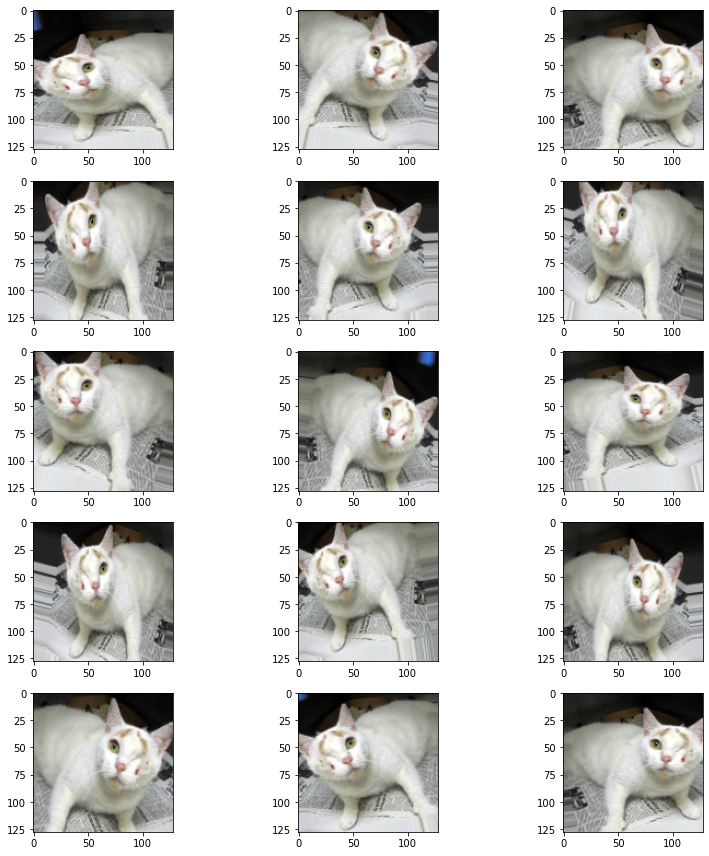

In [15]:
# Jetons un coup d'oeil sur l'effet de notre générateur sur une image de nos données
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "tree/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical'
)

# Visualisation
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### L'entrainement du modèle

In [16]:
# Training avec 15 epochs
history = model.fit_generator(
    train_generator, 
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 33,
    steps_per_epoch = 133,
    callbacks = [callbacks]
    
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 133 steps, validate for 33 steps
Epoch 1/15
133/133 [==============================] - 329s 2s/step - loss: 0.6791 - acc: 0.5860 - val_loss: 0.6218 - val_acc: 0.6509
Epoch 2/15
133/133 [==============================] - 362s 3s/step - loss: 0.5782 - acc: 0.6953 - val_loss: 0.5264 - val_acc: 0.7386
Epoch 3/15
133/133 [==============================] - 331s 2s/step - loss: 0.5176 - acc: 0.7437 - val_loss: 0.4638 - val_acc: 0.7818
Epoch 4/15
133/133 [==============================] - 365s 3s/step - loss: 0.4698 - acc: 0.7786 - val_loss: 0.4146 - val_acc: 0.8077
Epoch 5/15
133/133 [==============================] - 318s 2s/step - loss: 0.4493 - acc: 0.7910 - val_loss: 0.4132 - val_acc: 0.8095
Epoch 6/15
133/133 [==============================] - 384s 3s/step - loss: 0.4278 - acc: 0.8038 - val_loss: 0.4078 - val_acc: 0.8133
Epoch 7/15
133/133 [=============

In [17]:
# Sauvegarder le modèle
model.save("model2.h5")

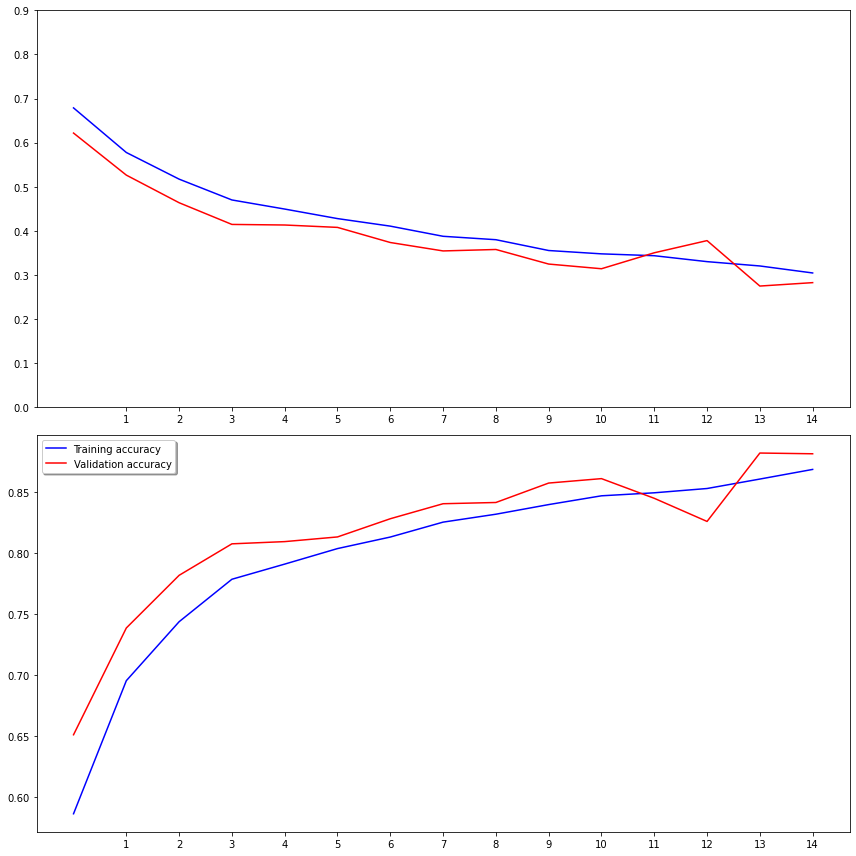

In [18]:
# Training et validation accuracy selon le nombre d'epochs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 15, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 15, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Création du dataframe du test

In [19]:
test_filenames = os.listdir("tree/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0] # Nombre d'images de test

### Création du générateur pour les données test

In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "tree/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=150,
    shuffle=False
)

Found 12500 validated image filenames.


### Prédiction

In [21]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/150))

Instructions for updating:
Please use Model.predict, which supports generators.


In [22]:
predict

array([[0.15602258, 0.8439774 ],
       [0.9959978 , 0.00400218],
       [0.75235397, 0.24764605],
       ...,
       [0.00961949, 0.9903805 ],
       [0.99579936, 0.00420064],
       [0.1841211 , 0.81587887]], dtype=float32)

In [23]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df.head()

,filename,category
0,1.jpg,1
1,10.jpg,0
2,100.jpg,0
3,1000.jpg,1
4,10000.jpg,1


In [24]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df.head()

,filename,category
0,1.jpg,dog
1,10.jpg,cat
2,100.jpg,cat
3,1000.jpg,dog
4,10000.jpg,dog


Text(0.5, 1.0, "Nombre d'images (dogs vs cats)")

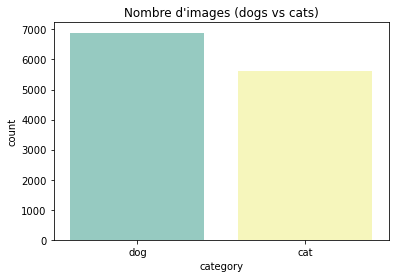

In [25]:
sn.countplot(x = "category", data = test_df, palette = "Set3")
plt.title("Nombre d'images (dogs vs cats)")

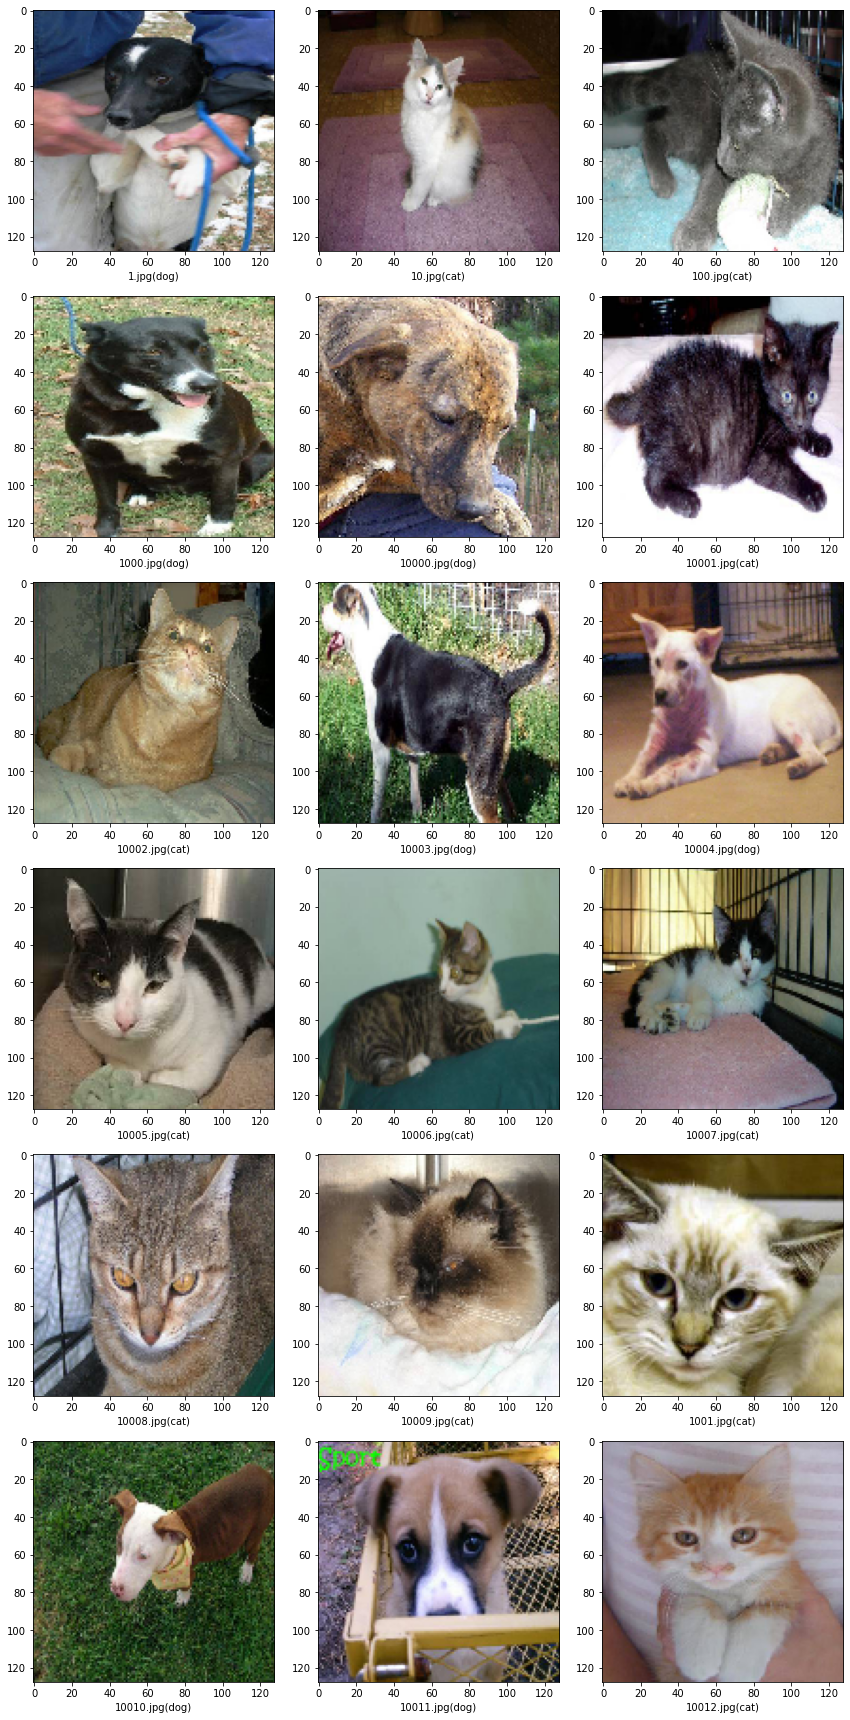

In [27]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("tree/test1/"+filename, target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()
